In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords  # stop words are, is, the etc. which are not needed for model
from nltk.stem.porter import PorterStemmer
!pip install gensim
from gensim.models import word2vec 
from sklearn.manifold import TSNE

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\swapg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# only for google colab
#from google.colab import files
#uploaded = files.upload()

In [3]:
#from StringIO import StringIO
#df = pd.read_csv(StringIO(uploaded['bbc-news-dataset.csv']))
df = pd.read_csv('bbc-news-dataset.csv')
df['category_id'] = df['category'].factorize()[0]

In [33]:
catid, catlable = df['category'].factorize()
catlable
import joblib
joblib.dump(catlable, 'Classificationt_catlabel.pkl')

['Classificationt_catlabel.pkl']

In [5]:
#create dictionary
category_id_df = df[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)

In [6]:
#df[df.news.str.contains('Arsenal')]



## Data Cleansing

In [7]:
def clean_str(string):
    """
    Tokenization/string cleaning for datasets.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"^b", "", string)
    string = re.sub(r"\\n ", "", string)
    string = re.sub(r"\'s", "", string)
    string = re.sub(r"\'ve", "", string)
    string = re.sub(r"n\'t", "", string)
    string = re.sub(r"\'re", "", string)
    string = re.sub(r"\'d", "", string)
    string = re.sub(r"\'ll", "", string)
    string = re.sub(r",", "", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", "", string)
    string = re.sub(r"\)", "", string)
    string = re.sub(r"\?", "", string)
    string = re.sub(r"'", "", string)
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"[0-9]\w+|[0-9]","", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

In [8]:
# df['news'].head()

In [9]:
!pip install textblob
import nltk
nltk.download('wordnet')
from textblob import Word
df['news'] = df['news'].apply(lambda x : (' '.join([Word(word).lemmatize() for word in clean_str(x).split()])) )

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\swapg\AppData\Roaming\nltk_data...


[nltk_data]   Package wordnet is already up-to-date!


In [10]:
df.sample(5, random_state=0)

,id,news,category,category_id
384,384,world leader gather to face uncertaintymore th...,business,0
1983,1983,uk iscriminated against rom the government imm...,politics,4
985,985,ferguson rue failure to cut gapboss sir alex f...,sport,1
1386,1386,u actor ossie davis found deadus actor ossie d...,entertainment,2
1294,1294,stern dropped from radio stationscontroversial...,entertainment,2


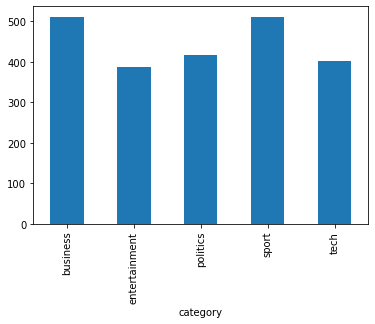

In [11]:
df.groupby('category').news.count().plot.bar(ylim=0)

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.news).toarray()

import joblib
joblib.dump(tfidf, 'Classificationtf.pkl')
labels = df.category_id
features.shape

(2225, 14364)

In [13]:
from sklearn.feature_selection import chi2
 
N = 3
for category, category_id in sorted(category_to_id.items()): # .itemsritems() is repled by .items() in python 3
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(category))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:]))) 

# 'business':
  . Most correlated unigrams:
       . oil
       . growth
       . bank
  . Most correlated bigrams:
       . analyst said
       . economic growth
       . stock market
# 'entertainment':
  . Most correlated unigrams:
       . actor
       . award
       . film
  . Most correlated bigrams:
       . los angeles
       . film festival
       . box office
# 'politics':
  . Most correlated unigrams:
       . election
       . tory
       . labour
  . Most correlated bigrams:
       . general election
       . prime minister
       . mr blair
# 'sport':
  . Most correlated unigrams:
       . champion
       . cup
       . match
  . Most correlated bigrams:
       . champion league
       . australian open
       . grand slam
# 'tech':
  . Most correlated unigrams:
       . technology
       . computer
       . user
  . Most correlated bigrams:
       . anti virus
       . let people
       . mobile phone


Will use [**t-SNE**](https://lvdmaaten.github.io/tsne/) for dimensionality reduction and plot cluster.

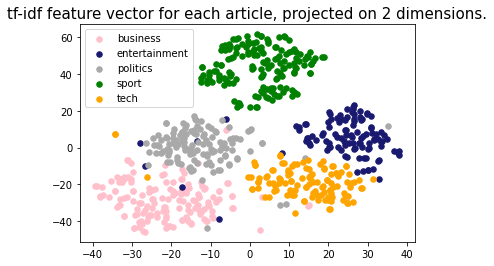

In [14]:
from sklearn.manifold import TSNE

# Sampling a subset of our dataset because t-SNE is computationally expensive
SAMPLE_SIZE = int(len(features) * 0.3)
np.random.seed(0)
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)
projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices])
colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']
for category, category_id in sorted(category_to_id.items()):
    points = projected_features[(labels[indices] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[category_id], label=category)
plt.title("tf-idf feature vector for each article, projected on 2 dimensions.",
          fontdict=dict(fontsize=15))
plt.legend()

In [15]:
df[df.news.str.contains('arsenal')]
#df.loc[df['id'] == 89]

,id,news,category,category_id
89,89,arsenal may seek full share listing arsenal vi...,business,0
568,568,poll explains free kick decisionreferee graham...,sport,1
569,569,bellamy fined after rownewcastle have fined th...,sport,1
572,572,spain coach face racism inquiryspain football ...,sport,1
573,573,strachan turn down pompeyformer southampton ma...,sport,1
580,580,parry firm over gerrardlisten to the full inte...,sport,1
600,600,henry tipped for fifa awardfifa president sepp...,sport,1
610,610,bridge could miss rest of seasonchelsea left b...,sport,1
632,632,wenger offer mutu hopearsenal bos arsene wenge...,sport,1
637,637,campbell lift lid on united feudarsenal sol ca...,sport,1


These outliers are little outliers so we can ignore.

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

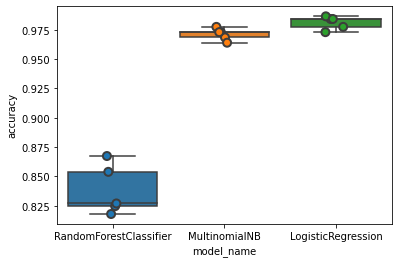

In [17]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

In [18]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LogisticRegression        0.981124
MultinomialNB             0.971236
RandomForestClassifier    0.838202
Name: accuracy, dtype: float64

### Train Test Split

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)

### Training

In [31]:
# Logistic Regression
model = LogisticRegression(random_state=0)
model.fit(X_train, y_train)
import joblib
joblib.dump(model, 'Classification.pkl')
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)
y_pred

array([4, 4, 1, 2, 2, 2, 2, 3, 2, 2, 4, 1, 2, 2, 2, 3, 0, 0, 3, 4, 1, 2,
       0, 2, 4, 0, 1, 0, 0, 0, 0, 3, 3, 3, 1, 0, 1, 3, 1, 2, 4, 4, 1, 1,
       2, 0, 4, 0, 0, 0, 0, 2, 0, 2, 4, 4, 3, 4, 0, 4, 0, 3, 2, 4, 2, 1,
       2, 0, 2, 1, 1, 3, 4, 2, 3, 2, 0, 2, 2, 1, 0, 1, 3, 0, 4, 4, 4, 0,
       1, 0, 0, 1, 0, 0, 1, 2, 3, 3, 2, 1, 3, 4, 2, 3, 1, 3, 1, 1, 0, 0,
       2, 1, 0, 1, 1, 1, 2, 1, 4, 2, 1, 3, 4, 4, 1, 4, 3, 0, 3, 1, 3, 3,
       1, 1, 0, 0, 1, 1, 1, 1, 3, 1, 1, 0, 1, 2, 3, 0, 1, 0, 4, 1, 2, 2,
       4, 0, 1, 1, 1, 3, 0, 2, 1, 0, 4, 4, 0, 0, 0, 0, 0, 3, 1, 2, 3, 2,
       4, 0, 0, 1, 3, 4, 3, 4, 3, 4, 4, 1, 2, 0, 2, 3, 0, 1, 2, 1, 0, 2,
       1, 2, 0, 1, 3, 4, 3, 4, 1, 0, 4, 1, 0, 4, 0, 0, 3, 3, 2, 0, 2, 3,
       4, 0, 4, 0, 1, 3, 0, 0, 0, 4, 1, 3, 1, 0, 1, 0, 0, 4, 4, 1, 0, 4,
       2, 1, 4, 2, 2, 3, 3, 0, 1, 0, 0, 1, 2, 3, 1, 2, 4, 3, 0, 0, 2, 2,
       2, 4, 3, 3, 4, 4, 1, 0, 2, 4, 0, 2, 1, 1, 2, 0, 2, 2, 1, 1, 0, 1,
       1, 4, 4, 1, 0, 1, 4, 2, 2, 4, 0, 0, 4, 4, 3,

### Validation

In [21]:
# Validation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.9836734693877551
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       173
           1       0.99      1.00      1.00       172
           2       0.99      0.98      0.99       123
           3       0.99      0.98      0.99       132
           4       0.96      0.97      0.97       135

    accuracy                           0.98       735
   macro avg       0.98      0.98      0.98       735
weighted avg       0.98      0.98      0.98       735



Text(0.5, 15.0, 'Predicted')

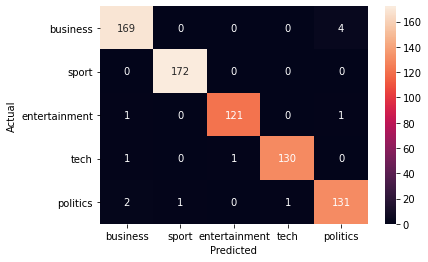

In [22]:
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [23]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 2:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['news']])
      print('')

'politics' predicted as 'business' : 2 examples.


,news
2129,super union merger plan toutedtwo of britain b...
2198,super union merger plan toutedtwo of britain b...



'business' predicted as 'politics' : 4 examples.


,news
384,world leader gather to face uncertaintymore th...
425,saudi ministry to employ womenwomen will be em...
249,ban on forced retirement under will no longer ...
1,aid and climate top davos agendaclimate change...


In [24]:
model.fit(features, labels)

LogisticRegression(random_state=0)

In [25]:
from sklearn.feature_selection import chi2

N = 5
for category, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(category))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'business':
  . Top unigrams:
       . company
       . firm
       . bank
       . market
       . share
  . Top bigrams:
       . chief executive
       . xc xa
       . stock market
       . analyst said
       . economic growth
# 'entertainment':
  . Top unigrams:
       . film
       . star
       . award
       . music
       . singer
  . Top bigrams:
       . box office
       . los angeles
       . new york
       . film festival
       . single chart
# 'politics':
  . Top unigrams:
       . party
       . labour
       . minister
       . mr
       . government
  . Top bigrams:
       . mr blair
       . general election
       . prime minister
       . mr brown
       . liberal democrat
# 'sport':
  . Top unigrams:
       . match
       . club
       . player
       . game
       . coach
  . Top bigrams:
       . year old
       . australian open
       . bbc sport
       . grand slam
       . champion league
# 'tech':
  . Top unigrams:
       . computer
       . user
     

In [26]:
df[df.news.str.lower().str.contains('news website')].category.value_counts()

tech             69
politics          8
entertainment     7
business          1
Name: category, dtype: int64

In [27]:
texts = ["Hooli stock price soared after a dip in PiedPiper revenue growth.",
         "Captain Tsubasa scores a magnificent goal for the Japanese team.",
         "Merryweather mercenaries are sent on another mission, as government oversight groups call for new sanctions.",
         "Beyoncé releases a new album, tops the charts in all of south-east Asia!",
         "You won't guess what the latest trend in data analysis is!"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"Hooli stock price soared after a dip in PiedPiper revenue growth."
  - Predicted as: 'business'

"Captain Tsubasa scores a magnificent goal for the Japanese team."
  - Predicted as: 'sport'

"Merryweather mercenaries are sent on another mission, as government oversight groups call for new sanctions."
  - Predicted as: 'politics'

"Beyoncé releases a new album, tops the charts in all of south-east Asia!"
  - Predicted as: 'entertainment'

"You won't guess what the latest trend in data analysis is!"
  - Predicted as: 'tech'



# Load Original fake news data to add feature

In [28]:
#uploaded = files.upload() # only for google colab

In [29]:
#from StringIO import StringIO   # google colab
#df1 = pd.read_csv(StringIO(uploaded['../dataset/fake_real_dataset_spam_category_clickbait_toxicity.csv']))
df1 = pd.read_csv('fake_real_dataset_spam_category_clickbait_toxicity.csv')

FileNotFoundError: [Errno 2] File ../dataset/fake_real_dataset_spam_category_clickbait_toxicity.csv does not exist: '../dataset/fake_real_dataset_spam_category_clickbait_toxicity.csv'

In [ ]:
def combine_column(tuple1):
    if(pd.notna(tuple1[1])):
        if(tuple1[1].strip(' \t\n\r') == ''):
            return 'NA'
        else:
            return tuple1[1]
    elif(pd.notna(tuple1[0])):
        if(tuple1[0].strip(' \t\n\r') == ''):
            return 'NA'
        else:
            return tuple1[0]   
    else:
            return 'NA'

In [ ]:
df1['content'] = df1[['title', 'text']].apply(combine_column, axis=1)

In [ ]:
text_features1 = tfidf.transform(df1['content'])

In [ ]:
#predictions
output1 = model.predict(text_features1)

In [ ]:
df_output = pd.DataFrame(data=output1, columns=['category_factor'])

In [ ]:
df1['category_factor'] = df_output.apply(lambda x:catlable[x])[['category_factor']]

In [ ]:
df1.sample(5, random_state=0)

In [ ]:
df1.to_csv('../dataset/fake_real_dataset_spam_category_clickbait_toxicity.csv')